# setup and imports

In [1]:
import fnmatch
import matplotlib.pyplot as plt
from ipywidgets import interactive
import numpy as np
import os
import glob
import pickle
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/test.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 26 rats in the data folder


In [3]:
rat_markers = {}
sequence = {}


TM1_pfPOS = [16.1, 97.3]
TM2_pfPOS = [17.2, 98.1]
TM1_virtualBoundary = [34.55, 80]  # in behav_params, should read_params(root, animal, session, "boundaryLeft")/11 ; read_params(root, animal, session, "boundaryRight")/11, but no change across sessions
TM2_virtualBoundary = [34.55, 80]


pfPOS = {'RatF00':TM1_pfPOS, 'RatF01':TM1_pfPOS, 'RatF02':TM1_pfPOS, 'RatF03':TM1_pfPOS, 
         'RatM00':TM2_pfPOS, 'RatM01':TM2_pfPOS, 'RatM02':TM2_pfPOS, 'RatM03':TM2_pfPOS}
virtualBoundary = {'RatF00':TM1_virtualBoundary, 'RatF01':TM1_virtualBoundary, 'RatF02':TM1_virtualBoundary, 'RatF03':TM1_virtualBoundary, 
                   'RatM00':TM2_virtualBoundary, 'RatM01':TM2_virtualBoundary, 'RatM02':TM2_virtualBoundary, 'RatM03':TM2_virtualBoundary}


# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
           'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
           'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
           'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
           'RatF42': (0.8, 0.2, 0.2), 'RatM40': (0.13, 0.55, 0.13), 'RatM43': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal'
               }

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[palette[animal], markers[brainstatus[animal]], lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[palette[animal], markers[brainstatus[animal]], lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        # get the preprocessed data from the pickle file
        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43


In [4]:
params = {}
smoothMask = {}
nb_runsBin = {}
rat_markers = {}
speedRunToLeftBin, speedRunToRightBin = {}, {}
timeRunToLeftBin, timeRunToRightBin = {}, {}
maxSpeedLeftBin, maxSpeedRightBin = {}, {}
timeStayInLeftBin, timeStayInRightBin = {}, {}
totalDistance, totalWater, total_trials = {}, {}, {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
sequence = {}


palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2), 'RatF03': (1, 0.6, 0.6),
            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2), 'RatM03': (0.6, 1.0, 0.6)}

# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal', 'RatF03': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal', 'RatM03': 'normal'}

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02',]

for index, animal in enumerate(animalList):
    print(animal)
    if fnmatch.fnmatch(animal, 'RatF*'): rat_markers[animal]=[palette[animal], "$\u2640$", brainstatus_plot(brainstatus[animal])]
    elif fnmatch.fnmatch(animal, 'RatM*'): rat_markers[animal]=[palette[animal], "$\u2642$", brainstatus_plot(brainstatus[animal])]
    elif fnmatch.fnmatch(animal, 'Rat00*'): rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$", brainstatus_plot(brainstatus[animal])]
    else: print("error, this is not a rat you got here")

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
        smoothMask[animal, session] = get_from_pickle(root, animal, session, name="mask.p")
        nb_runsBin[animal, session] = get_from_pickle(root, animal, session, name="nbRuns.p")
        speedRunToLeftBin[animal, session],  speedRunToRightBin[animal, session]  = get_from_pickle(root, animal, session, name="avgSpeed.p")
        maxSpeedLeftBin[animal, session],    maxSpeedRightBin[animal, session]    = get_from_pickle(root, animal, session, name="maxSpeed.p")
        timeStayInLeftBin[animal, session],  timeStayInRightBin[animal, session]  = get_from_pickle(root, animal, session, name="timeinZone.p")
        timeRunToLeftBin[animal, session],   timeRunToRightBin[animal, session]   = get_from_pickle(root, animal, session, name="timeRun.p")
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackPos.p")
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal, session, name="trackSpeed.p")
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackTime.p")
        totalDistance[animal, session],      totalWater[animal, session], total_trials[animal, session] = get_from_pickle(root, animal, session, name="misc.p")



data60, data90, data120 = separate_data(animalList, dist60+dist90+dist120, XtrackRunToLeftBin, XtrackRunToRightBin, 'Distance', params, 'avgrunspeed', True)
datat60, datat90, datat120 = separate_data(animalList, dist60+dist90+dist120, trackTimeToLeftBin, trackTimeToRightBin, 'Distance', params, 'avgrunspeed', True)
sdata60, sdata90, sdata120 = separate_data(animalList, dist60+dist90+dist120, instantSpeedLeftBin, instantSpeedRightBin, 'Distance', params, 'avgrunspeed', True)
# sdatat60, sdatat90, sdatat120 = separate_data(animalList, dist60+dist90+dist120, trackTimeToLeftBin, trackTimeToRightBin, 'Distance', params, 'avgrunspeed', True)

datarev20, datarev10, datarev2, data2, data10, data20 = separate_data(animalList, TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, XtrackRunToLeftBin, XtrackRunToRightBin, 'TM_ON', params, 'avgrunspeed', True)
datatrev20, datatrev10, datatrev2, datat2, datat10, datat20 = separate_data(animalList, TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, trackTimeToLeftBin, trackTimeToRightBin, 'TM_ON', params, 'avgrunspeed', True)
sdatarev20, sdatarev10, sdatarev2, sdata2, sdata10, sdata20 = separate_data(animalList, TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, instantSpeedLeftBin, instantSpeedRightBin, 'TM_ON', params, 'avgrunspeed', True)
# sdatarevt20, sdatarevt10, sdatarevt2, sdatat2, sdatat10, sdatat20 = separate_data(animalList, TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, trackTimeToLeftBin, trackTimeToRightBin, 'TM_ON', params, 'avgrunspeed', True)


RatF00
RatF01
RatF02
RatM00
RatM01
RatM02


/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


# A, Raw speed profile for 1 animal in all conditions, first block of last AM session
# B, Rescaled speed profile

In [44]:
from VIGOR_Functions import compute_median_trajectory

def plot_speed_profile(posdataRight, timedataRight, xylim,
                color, xyLabels=["", ""], ax=None):

    '''Plot speed profile for each run
    Args:
        posdataRight: list of lists, position data for each run
        timedataRight: list of lists, time data for each run
        xylim: list of 4 scalars, x and y limits for the plot
        color: list of 2 colors, color of the plot
        xyLabels: list of 2 strings, x and y labels for the plot
        ax: matplotlib axis object, if None, create a new figure and axis
    Returns:
        ax: matplotlib axis object
    '''
    if ax is None:
        ax = plt.gca()

    for pos, time in zip(posdataRight, timedataRight):
        t = np.subtract(time, time[0])
        abs_speed = [abs(_) for _ in pos]
        ax.plot(t, abs_speed, color=color[0], linewidth=0.2, alpha=0.5)

    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel(xyLabels[1])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    return ax

def removeTMspeed(datap, datas, TMspeed, pfPOS, virtualBoundary, k=.5):

    """remove treadmill speed between platform and virtual boundary
        for speed profiles in which the treadmill is on
    Args:
        datap: list of lists, position data for each run
        datas: list of lists, speed data for each run
        TMspeed: scalar, treadmill speed
        pfPOS: list of 2 scalars, platform position
        virtualBoundary: list of 2 scalars, virtual boundary position
        k: scalar, steepness of the function
    Returns:
        output: list of lists, corrected speed data for each run
    """
    def _correctTM(x, k=k, mu1=20, mu2=85, amp=20):
        """
        (approximation of the Heaviside function)
        Args:
            x: scalar, position 
            k: scalar, steepness of the function 
            mu1: scalar, start location, end of platform
            mu2: scalar, end location, virutal boundary location
            amp: scalar, height of the  function, treadmill speed
        Returns:
            p: scalar, f(x)
        """  
        LEFT = 1/(1+np.exp(-k*(x-mu1)))
        RIGHT = 1/(1+np.exp(k*(x-mu2)))
        return LEFT * RIGHT * amp

    output = copy.deepcopy(datas)

    if np.all([isinstance(dat, float) for dat in datap]):  # if only one run is available
        for j, (pos, speed) in enumerate(zip(datap, datas)):  # loop through time points in a run
            if datap[0] < datap[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
            elif datap[0] > datap[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    else:
        for i, (positionarray, speedarray) in enumerate(zip(datap, datas)):  # loop through individual runs
            for j, (pos, speed) in enumerate(zip(positionarray, speedarray)):  # loop through time points in a run
                if positionarray[0] < positionarray[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
                elif positionarray[0] > positionarray[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    return output


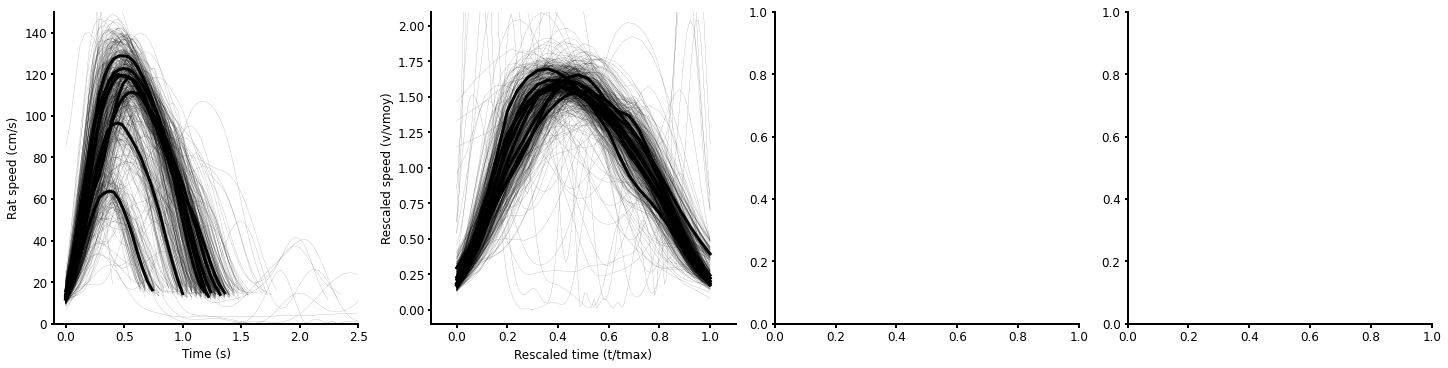

In [45]:
# A, plot speed profiles for each experimental condition
# B, same but rescaled


fig, ax = plt.subplots(1, 4, figsize=(20, 5))

animal = 'RatF01'  # sample animal
index_session_example = -2  #last AM session
index_block_example = 0 # first block

for condition in [dist60, dist90, dist120, TM20, TM10, TM2, TMrev10, TMrev20]:
    session = matchsession(animal, condition)[index_session_example]
    example_time = trackTimeToRightBin[animal, session][index_block_example]

    # keep treadmill speed for dist sessions
    if session in dist60+dist90+dist120:
        example_speed = instantSpeedRightBin[animal, session][index_block_example]
    
    # remove treadmill speed for TM sessions
    elif session in TM20+TM10+TM2+TMrev10+TMrev20:
        p = XtrackRunToRightBin[animal, session][index_block_example]
        s = instantSpeedRightBin[animal, session][index_block_example]
        t = trackTimeToRightBin[animal, session][index_block_example]
        tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
        example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

    # plot individual speed profiles
    plot_speed_profile(example_speed, example_time, 
                xylim = [-0.1, 2.5, 0, 150], color='k', 
                xyLabels=["Time (s)","Rat speed (cm/s)"], ax=ax[0]) 

    # plot median trajectory
    ax[0].plot(*compute_median_trajectory(example_speed, example_time), 
                color= 'k', lw=3, alpha=1, zorder = 3)




    #rescale by average speed and movement time
    rescaled_time = copy.deepcopy(example_time)
    for i in range(len(example_time)):
        rescaled_time[i] = np.array(example_time[i])/(example_time[i][-1]-example_time[i][0])

    rescaled_speed = copy.deepcopy(example_speed)
    for i in range(len(example_speed)):
        rescaled_speed[i] = np.array(example_speed[i])/np.nanmean(example_speed[i])

    # plot
    plot_speed_profile(rescaled_speed, rescaled_time,
                xylim = [-0.1, 1.1, -.1, 2.1], color='k',
                xyLabels=["Rescaled time (t/tmax)","Rescaled speed (v/vmoy)"], ax=ax[1])
    
    # plot median trajectory
    ax[1].plot(*compute_median_trajectory(rescaled_speed, rescaled_time), 
                color= 'k', lw=3, alpha=1, zorder = 3)

                

# C, Speed profiles annotations

Text(0.55, 0.075, 'vbelt')

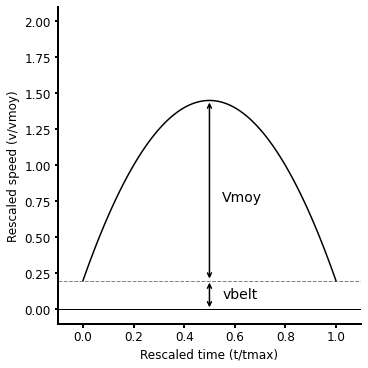

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_xlabel("Rescaled time (t/tmax)")
ax.set_ylabel("Rescaled speed (v/vmoy)")
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-.1, 2.1])

# vbelt
VBELT = 0.2
ax.axhline(VBELT, color='k', lw=1, alpha=0.5, linestyle='--')
ax.axhline(0, color='k', lw=1)


# parabola
def _simple_parabola(x, a, b, c):
    return a * x**2 + b * x + c

y = _simple_parabola(np.linspace(0, 1, 100), -5, 5, VBELT)
ax.plot(np.linspace(0, 1, 100), y, color='k')


# annotations and arrows
ax.annotate(text='', xy=(np.argmax(y)/100, np.max(y)), 
            xytext=(np.argmax(y)/100, VBELT), 
            arrowprops=dict(arrowstyle='<->', color='k', lw=1.5))
ax.annotate(text='Vmoy', xy=(0.55, 0.75), fontsize=14)

ax.annotate(text='', xy=(np.argmax(y)/100, 0), 
            xytext=(np.argmax(y)/100, VBELT), 
            arrowprops=dict(arrowstyle='<->', color='k', lw=1.5))
ax.annotate(text='vbelt', xy=(0.55, 0.075), fontsize=14)

# Our model and CR comparison

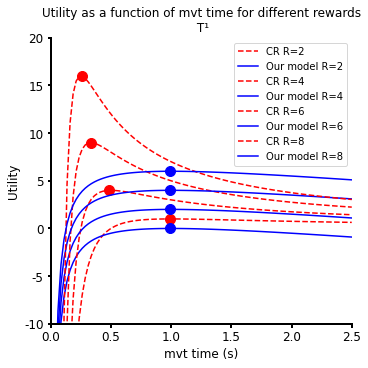

In [35]:
# max((R-E)/T) vs max R-E -T

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# effort cost for a movement of duration T, distance D, with a belt speed of vbelt
def effort_cost(T, D=1, alpha=1, vbelt=0):
    return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)

# CR utility for a movement of duration T, distance D, with a belt speed 
# of vbelt, and a reward of R
# U = (R - effort_cost) / T
def utility_CR(R, T, D, VBELT):
    cost = effort_cost(T, D, alpha=1, vbelt=VBELT)
    return (R - cost) / T

# our model utility for a movement of duration T, distance D, with a belt speed 
# of vbelt, and a reward of R
# U = R - effort_cost - T^power
def utility_our_model(R, T, D, VBELT, power=1):
    cost = effort_cost(T, D, alpha=1, vbelt=VBELT)
    return R - cost - T**power


T = np.linspace(0.01, 2.5, 100)
for R in [2, 4, 6, 8]:  # reward size
    # plot max((R-E)/T) vs max R-E -T
    # line is utility, dot is Topt
    ax.plot(T, utility_CR(R, T, 1, 0), label=f'CR R={R}', ls='--', c='r')
    ax.scatter(T[np.argmax(utility_CR(R, T, 1, 0))], np.max(utility_CR(R, T, 1, 0)), color='r', s=100)

    ax.plot(T, utility_our_model(R, T, 1, 0), label=f'Our model R={R}', ls='-', c='b')
    ax.scatter(T[np.argmax(utility_our_model(R, T, 1, 0))], np.max(utility_our_model(R, T, 1, 0)), color='b', s=100)

ax.set_xlabel("mvt time (s)")
ax.set_ylabel("Utility")
ax.set_xlim([0, 2.5])
ax.set_ylim([-10, 20])
ax.set_title("Utility as a function of mvt time for different rewards\n T¹")
ax.legend()


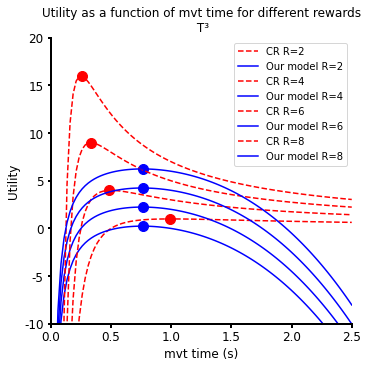

In [47]:
# same as previous cell, but time ~ T**3

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

T = np.linspace(0.01, 2.5, 100)
for R in [2, 4, 6, 8]:

    ax.plot(T, utility_CR(R, T, 1, 0), label=f'CR R={R}', ls='--', c='r')
    ax.scatter(T[np.argmax(utility_CR(R, T, 1, 0))], np.max(utility_CR(R, T, 1, 0)), color='r', s=100)

    ax.plot(T, utility_our_model(R, T, 1, 0, power=3), label=f'Our model R={R}', ls='-', c='b')
    ax.scatter(T[np.argmax(utility_our_model(R, T, 1, 0, power=3))], np.max(utility_our_model(R, T, 1, 0, power=3)), color='b', s=100)

ax.set_xlabel("mvt time (s)")
ax.set_ylabel("Utility")
ax.set_xlim([0, 2.5])
ax.set_ylim([-10, 20])
ax.set_title("Utility as a function of mvt time for different rewards\n T³")
ax.legend()


# model predictions

$v(t) = v_{belt} + V_{max} \tilde{v}(\tilde{t})$ &emsp; <font color='grey'> with $\tilde{v}(\tilde{t})$ universal speed function </font>  
<br>

$x(t_f) = d = v_{belt}*t_f + V_{max}t_f V_0 $   &emsp; <font color='black'> with $V_0 = \int_0^1 \tilde{v}(\tilde{t})d\tilde{t}$ universal constant </font>  
<br>  

$V_{max} = \frac{d-v_{belt} t_f}{V_0 t_f} = \frac{1}{V_0}[\frac{d}{t_f} -v_{belt}] $  
<br>  

# $C_M$ 
$C_M = \alpha V_{max}^2 t_f V_1$ &emsp; and &emsp; $V_{max} = \frac{d-v_{belt} t_f}{V_0 t_f}$  
$C_M = \alpha (\frac{d-v_{belt}t_f}{V_0t_f})^2 t_f V_1$  
$C_M = \tilde{\alpha} [\frac{d^2}{t_f}-2dv_{belt} + v_{belt}^2 t_f]$  &emsp; <font color='black'> with $\tilde{\alpha} = \frac{\alpha V_1}{V_0^2}$ universal constant </font>  
$C_M' = \tilde{\alpha} [\frac{-d^2}{t_f^2} + v_{belt}^2]$  

<br> 

# $T$ 
Time Cost: 
$C_T = t_f^n$ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $C_T' = nt_f^{n-1}$  
  
# $Total$ 
$C_{tot}' = \tilde{\alpha} [\frac{-d^2}{t_f^2} + v_{belt}^2] + nt_f^{n-1}$  

# $Analytical T_{opt}$
## n = 1 
$t_f^2 = \frac{\tilde{\alpha} d^2}{\tilde{\alpha} v_{belt}^2 + 1}$  
  
## n = 3  
$t_f^2 = \frac{-\alpha v_{belt}^2+\sqrt{\alpha^2 v_{belt}^4 + 12\alpha d²}}{6}$  


In [137]:
# compute optimal time for a given distance, belt speed, and reward size
# when time cost is T^1
def T_opt_n1(D, vbelt, alpha):
    Tsq = (alpha * D**2) / (1 + alpha * vbelt**2)
    return np.sqrt(Tsq)

# when time cost is T^3
def T_opt_n3(D, vbelt, alpha):
    _ = np.sqrt(alpha**2 * vbelt**4 + 12*alpha*D**2)
    Tsq = ((_ - (alpha * vbelt**2)) / 6)
    return np.sqrt(Tsq)


# our model predictions

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


(0.0, 5.0)

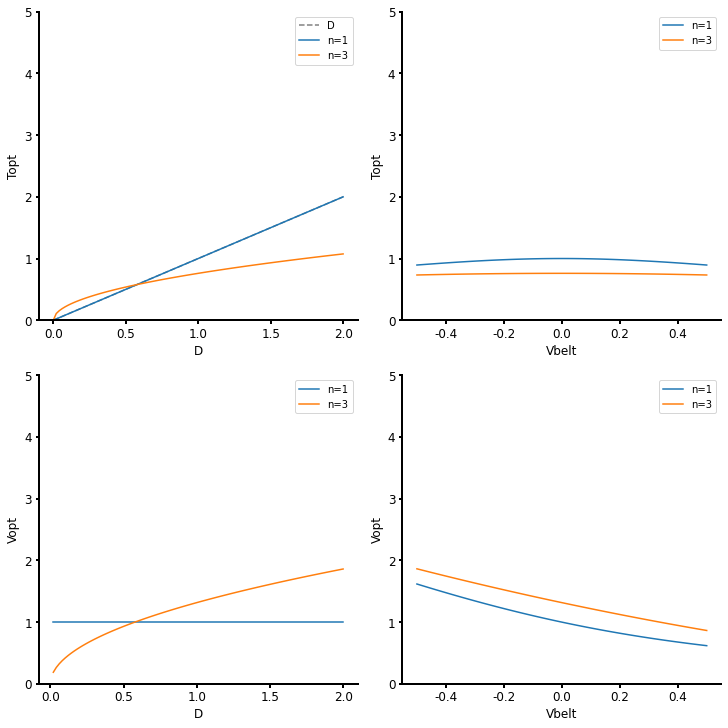

In [138]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

D_cst = 1
Vbelt_cst = 0
ALPHA = 1

D = np.linspace(0, 2, 100)
VBELT = np.linspace(.5, -.5, 100)

# Topt as a function of D
axs[0, 0].plot(D, D, alpha=0.5, label='D', linestyle='--', color='k')
axs[0, 0].plot(D, T_opt_n1(D, Vbelt_cst, ALPHA), label='n=1')
axs[0, 0].plot(D, T_opt_n3(D, Vbelt_cst, ALPHA), label='n=3')
axs[0, 0].legend()
axs[0, 0].set_xlabel('D')
axs[0, 0].set_ylabel('Topt')
axs[0, 0].set_ylim(0, 5)

# Topt as a function of Vbelt
axs[0, 1].plot(VBELT, T_opt_n1(D_cst, VBELT, ALPHA), label='n=1')
axs[0, 1].plot(VBELT, T_opt_n3(D_cst, VBELT, ALPHA), label='n=3')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Vbelt')
axs[0, 1].set_ylabel('Topt')
axs[0, 1].set_ylim(0, 5)

# Vopt as a function of D
axs[1, 0].plot(D, D/T_opt_n1(D, Vbelt_cst, ALPHA), label='n=1')
axs[1, 0].plot(D, D/T_opt_n3(D, Vbelt_cst, ALPHA), label='n=3')
axs[1, 0].legend()
axs[1, 0].set_xlabel('D')
axs[1, 0].set_ylabel('Vopt')
axs[1, 0].set_ylim(0, 5)

# Vopt as a function of Vbelt
axs[1, 1].plot(VBELT, D_cst/T_opt_n1(D_cst, VBELT, ALPHA) - VBELT, label='n=1')
axs[1, 1].plot(VBELT, D_cst/T_opt_n3(D_cst, VBELT, ALPHA) - VBELT, label='n=3')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Vbelt')
axs[1, 1].set_ylabel('Vopt')
axs[1, 1].set_ylim(0, 5)



In [119]:
# test T^power is a parameter 
def T_opt_n(D, vbelt, alpha, power):
    T = np.linspace(0.01, 2.5, 100)
    cost = ((alpha * (D - vbelt * T)**2) / T) + T**power
    Topt = T[np.argmin(cost)]

    return Topt

def T_opt_n(D, vbelt, alpha, power):
    T = np.linspace(0.0, 2.5, 100)
    cost = alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T) + T**power
    Topt = T[np.argmin(cost)]

    return Topt


/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encounter

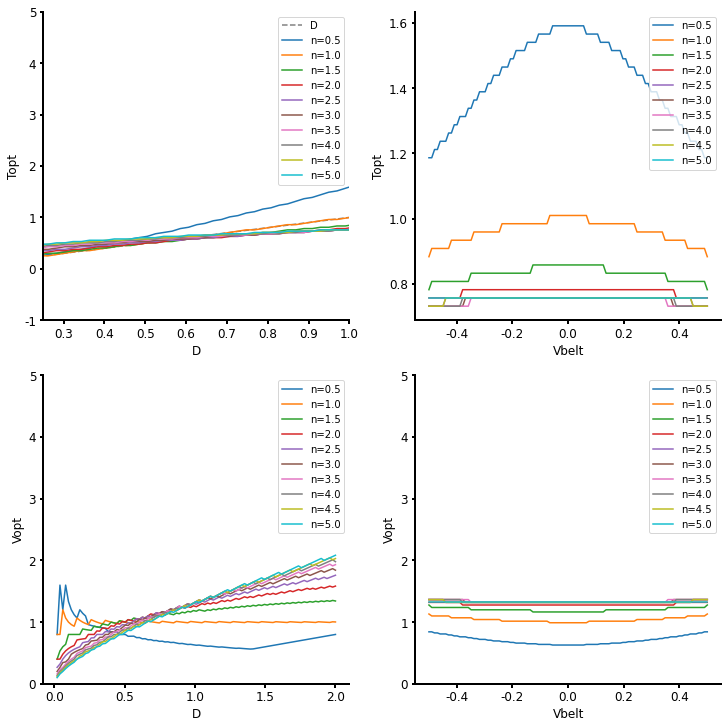

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

D_cst = 1
Vbelt_cst = 0
ALPHA = 1

D = np.linspace(0, 2, 100)
VBELT = np.linspace(.5, -.5, 100)

axs[0, 0].plot(D, D, alpha=0.5, label='D', linestyle='--', color='k')
    
for power in np.arange(0.5, 5.5, .5):
    # Topt as a function of D
    axs[0, 0].plot(D, [T_opt_n(d, Vbelt_cst, ALPHA, power) for d in D], label=f'n={power}')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('D')
    axs[0, 0].set_ylabel('Topt')
    axs[0, 0].set_ylim(-1, 5)
    axs[0, 0].set_xlim(.25, 1)

    # Topt as a function of Vbelt
    axs[0, 1].plot(VBELT, [T_opt_n(D_cst, vbelt, ALPHA, power) for vbelt in VBELT], label=f'n={power}')
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Vbelt')
    axs[0, 1].set_ylabel('Topt')

    # Vopt as a function of D
    axs[1, 0].plot(D, [d/T_opt_n(d, Vbelt_cst, ALPHA, power) for d in D], label=f'n={power}')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('D')
    axs[1, 0].set_ylabel('Vopt')
    axs[1, 0].set_ylim(0, 5)

    # Vopt as a function of Vbelt
    axs[1, 1].plot(VBELT, [D_cst/T_opt_n(D_cst, vbelt, ALPHA, power) for vbelt in VBELT], label=f'n={power}')
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Vbelt')
    axs[1, 1].set_ylabel('Vopt')
    axs[1, 1].set_ylim(0, 5)



# CAPTURE RATE PREDICTIONS


$CR = \frac{R-E}{T}$  
with:
$E = \tilde{\alpha} [\frac{d^2}{t_f}-2d v_{belt} + v_{belt}^2 t_f]$  
$T = t_f$

$CR = \frac{R-\tilde{\alpha} [\frac{d^2}{t_f}-2d v_{belt} + v_{belt}^2 t_f]}{t_f}$  
$CR = \frac{RT-\tilde{\alpha} [d - v_{belt} T]²}{T²}$

Max when $CR'=0$  
$CR' = \frac{-RT + 2 \alpha D² - 2 \alpha D v_{belt} T}{T⁴} = 0$  

$CR' = [R + 2 \alpha D v_{belt}]T = 2 \alpha D²$

$T = \frac{2 \alpha D²}{R + 2 \alpha D v_{belt}}$



In [50]:
def T_opt_CR(D, vbelt, alpha=1, R=1, ):
    return (2 * alpha * D**2) / (R + 2 * alpha * D * vbelt)

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(0.0, 2.5)

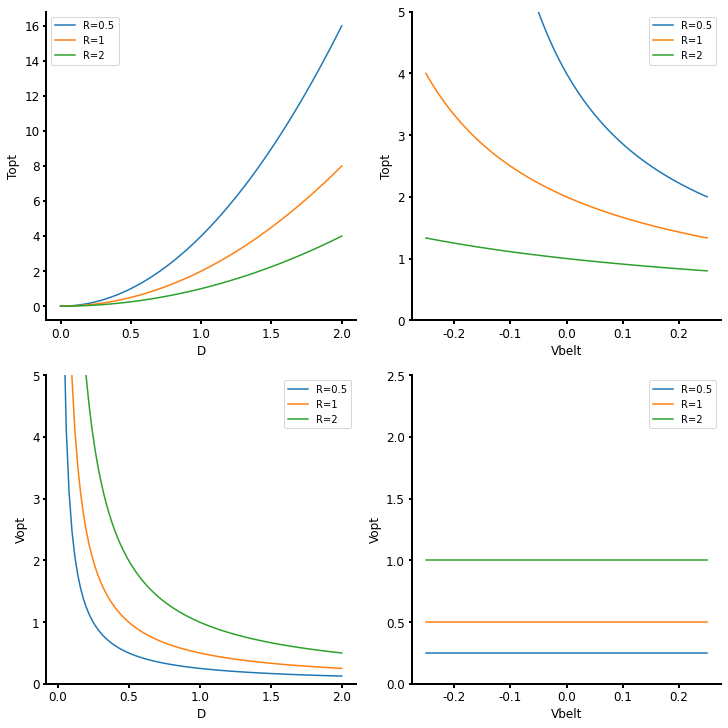

In [56]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

D_cst = 1
Vbelt_cst = 0
ALPHA = 1
RWD = 1

D = np.linspace(0, 2, 100)
VBELT = np.linspace(.25, -.25, 100)

# Topt as a function of D
for r in [0.5, 1, 2]:
    axs[0, 0].plot(D, T_opt_CR(D, Vbelt_cst, ALPHA, r), label=f'R={r}')
axs[0, 0].legend()
axs[0, 0].set_xlabel('D')
axs[0, 0].set_ylabel('Topt')

# Topt as a function of Vbelt
for r in [0.5, 1, 2]:
    axs[0, 1].plot(VBELT, T_opt_CR(D_cst, VBELT, ALPHA, r), label=f'R={r}')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Vbelt')
axs[0, 1].set_ylabel('Topt')
axs[0, 1].set_ylim(0, 5)

# Vopt as a function of D
for r in [0.5, 1, 2]:
    axs[1, 0].plot(D, D/T_opt_CR(D, Vbelt_cst, ALPHA, r), label=f'R={r}')
axs[1, 0].legend()
axs[1, 0].set_xlabel('D')
axs[1, 0].set_ylabel('Vopt')
axs[1, 0].set_ylim(0, 5)

# Vopt as a function of Vbelt
for r in [0.5, 1, 2]:
    axs[1, 1].plot(VBELT, (D_cst/T_opt_CR(D_cst, VBELT, ALPHA, r))-VBELT, label=f'R={r}')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Vbelt')
axs[1, 1].set_ylabel('Vopt')
axs[1, 1].set_ylim(0, 2.5)


# figure

In [58]:
# figure for paper


# bonus

In [33]:
def effort_cost(T, D=1, alpha=1, vbelt=0):
    return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)

def time_cost(T, beta=1, power=1):
    return beta*T ** power


def plot_model(D=1, vbelt=0, alpha=1, beta=1, power=1):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    T = np.linspace(0.1, 2.5, 100)
    ax.plot(T, effort_cost(T, D, alpha, vbelt), label='effort')
    ax.plot(T, time_cost(T, beta, power), label='time')
    ax.plot(T, effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power), label='total')
    # argmin of total cost
    ax.plot(T[np.argmin(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))], 
            np.min(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power)),
            'o', color='k', label='approx min')

    print(f'argmin: {T[np.argmin(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))]}')
    # # total derivative
    # dydx = np.diff(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))/np.diff(T)
    # ax.plot(T[:-1], dydx, label='total derivative', color='k', linestyle='--', alpha=0.5)

    # ax. axvline(T[np.argmin(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))],
    #             linestyle='--', color='k', alpha=0.5)

    ax.set_xlabel('T')
    ax.set_ylabel('cost')
    ax.legend()
    ax.set_title('Cost of a single trial')
    ax.set_ylim(0, 5)


interactive_plot = interactive(plot_model, D=(0, 2, .1), vbelt=(-.2, .2, 0.01), alpha=(0, 5.0, 0.5), beta=(0, 5, 0.5), power=(0, 5, .1))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='D', max=2.0), FloatSlider(value=0.0, description='vb…

(0.0, 10.0)

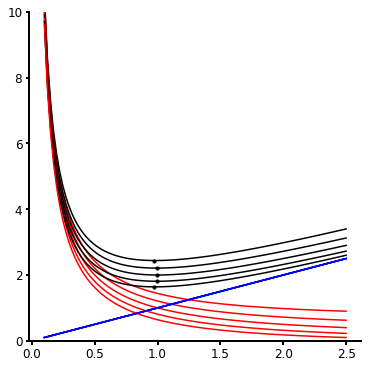

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

D = 1
alpha=beta= 1
x = np.linspace(-.2, .2, 100)
T = np.linspace(0.1, 2.5, 100)
power =1
for vbelt in [-.2, -.1, 0, .1, .2]:
    C = [effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power)]
    ax.scatter(T[np.argmin(C[0])], np.min(C[0]), color='k', s=10)
    ax.plot(T, C[0], label=f'vbelt={vbelt}', c='k')

    ax.plot(T, effort_cost(T, D, alpha, vbelt), label=f'vbelt={vbelt}', c='r')

    ax.plot(T, time_cost(T, beta, power), label=f'vbelt={vbelt}', c='b')

# ax.plot(x, Topt)

ax.set_ylim(0, 10)

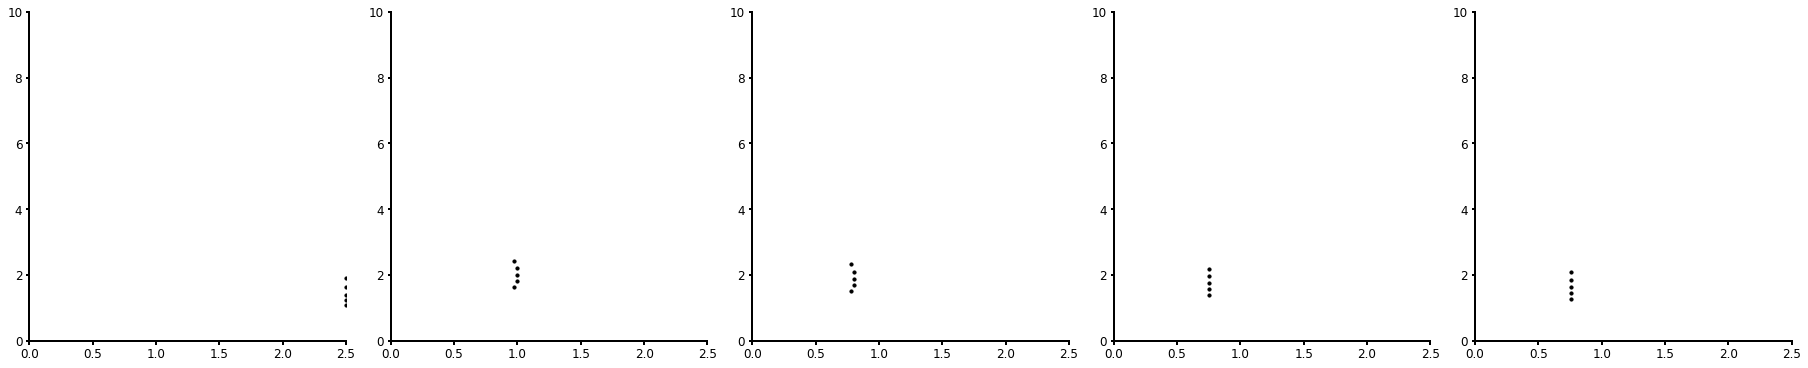

In [18]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

D = 1
alpha=beta= 1
x = np.linspace(-.2, .2, 100)
T = np.linspace(0.1, 2.5, 100)
for power in np.arange(5):
    for vbelt in [-.2, -.1, 0, .1, .2]:
        C = [effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power)]
        ax[power].scatter(T[np.argmin(C[0])], np.min(C[0]), color='k', s=10)
        # ax.plot(T, C[0], label=f'vbelt={vbelt}', c='k')

        # ax.plot(T, effort_cost(T, D, alpha, vbelt), label=f'vbelt={vbelt}', c='r')

        # ax.plot(T, time_cost(T, beta, power), label=f'vbelt={vbelt}', c='b')

    # ax.plot(x, Topt)

    ax[power].set_ylim(0, 10)
    ax[power].set_xlim(0, 2.5)

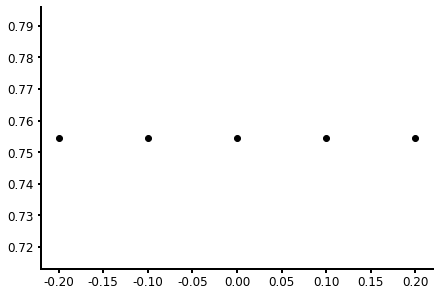

In [19]:
C = [effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power) for vbelt in [-.2, -.1, 0, .1, .2]]
for x, c in zip([-.2, -.1, 0, .1, .2], C):
    plt.plot(x, T[np.argmin(c)], 'o', color='k')
    # print(x, T[np.argmin(c)])

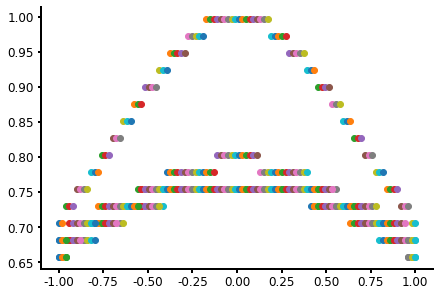

In [20]:

vb = np.linspace(-1, 1, 100)
for power in [1, 2, 3, 4, 5]:
    C = [effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power) for vbelt in vb]
    for x, c in zip(vb, C):
        plt.plot(x, T[np.argmin(c)], 'o',)
        # print(power, x, T[np.argmin(c)])

[0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996969696969697, 0.996

Text(0.5, 1.0, 'Topt as a function of vbelt')

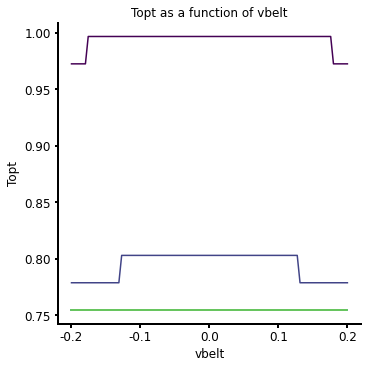

In [21]:
D = 1
alpha = 1
beta = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))


for c, power in enumerate([1, 2, 3, 4, 5]):
    x = np.linspace(-.2, .2, 100)
    T = np.linspace(0.1, 2.5, 100)
    Topt = [T[np.argmin(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))] for vbelt in x]
    print(Topt)
    # Topt /= np.max(Topt)
    ax.plot(x, Topt, color=plt.cm.viridis(c/len([1, 2, 3, 4, 5])), label=f'Topt {power}')
ax.set_xlabel('vbelt')
ax.set_ylabel('Topt')
ax.set_title('Topt as a function of vbelt')


In [ ]:
def effort_cost(T, D=1, alpha=1, vbelt=0):
    return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)

def time_cost(T, beta=1, power=1):
    return beta*T ** power

In [123]:
def T_opt_n(D, vbelt, alpha, power):
    T = np.linspace(0.0, 2.5, 100)
    cost = alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T) + T**power
    Topt = T[np.argmin(cost)]

    return Topt

def plot_(D=1, vbelt=0, alpha=1, beta=1, power=1):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    T = np.linspace(0., 2.5, 100)
    ax.plot(T, effort_cost(T, D, alpha, vbelt), label='effort')
    ax.plot(T, time_cost(T, beta, power), label='time')
    ax.plot(T, effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power), label='total')
    # argmin of total cost
    ax.plot(T[np.argmin(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))], 
            np.min(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power)),
            'o', color='k', label='approx min')

    # ax.plot(T, T_opt_n(D, vbelt, alpha, power), label='Topt approx')


    ax.set_xlabel('T')
    ax.set_ylabel('cost')
    ax.legend()
    ax.set_title('Cost of a single trial')
    ax.set_ylim(0, 5)


interactive(plot_, D=(0, 2, .1), vbelt=(-.2, .2, 0.01), alpha=(0, 5.0, 0.5), beta=(0, 5, 0.5), power=(0, 5, .1))


interactive(children=(FloatSlider(value=1.0, description='D', max=2.0), FloatSlider(value=0.0, description='vb…

In [139]:
def T_opt_n1(D, vbelt, alpha):
    Tsq = (alpha * D**2) / (1 + alpha * vbelt**2)
    return np.sqrt(Tsq)

# when time cost is T^3
def T_opt_n3(D, vbelt, alpha):
    _ = np.sqrt(alpha**2 * vbelt**4 + 12*alpha*D**2)
    Tsq = ((_ - (alpha * vbelt**2)) / 6)
    return np.sqrt(Tsq)

def T_opt_n(D, vbelt, alpha, power):
    T = np.linspace(0.0, 2.5, 100)
    cost = alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T) + T**power
    Topt = T[np.argmin(cost)]
    return Topt

D = 2
alpha = 1
vbelt = 0

print(T_opt_n1(D, vbelt, alpha))
print(T_opt_n3(D, vbelt, alpha))
print(T_opt_n(D, vbelt, alpha, 1))

2.0
1.074569931823542
1.9949494949494948


/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


(0.0, 2.5)

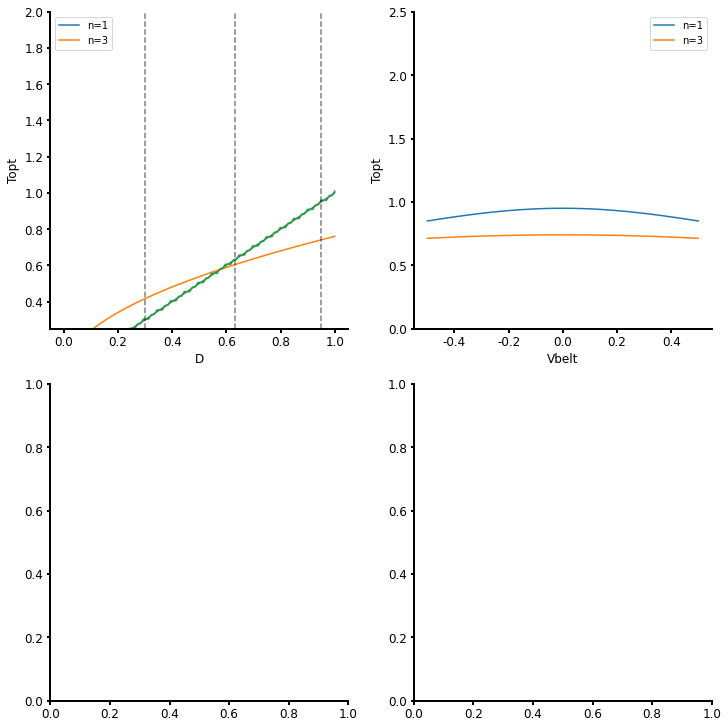

In [140]:



fig, axs = plt.subplots(2, 2, figsize=(10, 10))

D_cst = .95
Vbelt_cst = 0
ALPHA = 1

D = np.linspace(0, 1, 100)
VBELT = np.linspace(.5, -.5, 100)

# Topt as a function of D
axs[0, 0].plot(D, T_opt_n1(D, Vbelt_cst, ALPHA), label='n=1')
axs[0, 0].plot(D, T_opt_n3(D, Vbelt_cst, ALPHA), label='n=3')
axs[0, 0].plot(D, [T_opt_n(d, Vbelt_cst, ALPHA, power=1) for d in D], label='')
axs[0, 0].legend()
axs[0, 0].set_xlabel('D')
axs[0, 0].set_ylabel('Topt')
axs[0, 0].set_ylim(.25, 2)
axs[0, 0].axvline(.3, color='k', alpha=0.5, linestyle='--')
axs[0, 0].axvline(.63, color='k', alpha=0.5, linestyle='--')
axs[0, 0].axvline(.95, color='k', alpha=0.5, linestyle='--')

# Topt as a function of Vbelt
axs[0, 1].plot(VBELT, T_opt_n1(D_cst, VBELT, ALPHA), label='n=1')
axs[0, 1].plot(VBELT, T_opt_n3(D_cst, VBELT, ALPHA), label='n=3')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Vbelt')
axs[0, 1].set_ylabel('Topt')
axs[0, 1].set_ylim(0, 2.5)



In [141]:
def T_opt_n1(D, vbelt, alpha):
    Tsq = (alpha * D**2) / (1 + alpha * vbelt**2)
    return np.sqrt(Tsq)
    
# when time cost is T^3
def T_opt_n3(D, vbelt, alpha):
    _ = np.sqrt(alpha**2 * vbelt**4 + 12*alpha*D**2)
    Tsq = ((_ - (alpha * vbelt**2)) / 6)
    return np.sqrt(Tsq)

def test(ALPHA=2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    D_cst = .95
    Vbelt_cst = 0


    D = np.linspace(0, 1, 100)
    VBELT = np.linspace(.5, -.5, 100)

    # Topt as a function of D
    axs[0].plot(D, T_opt_n1(D, Vbelt_cst, ALPHA), label='n=1')
    axs[0, ].plot(D, T_opt_n3(D, Vbelt_cst, ALPHA), label='n=3')
    axs[0, ].legend()
    axs[0, ].set_xlabel('D')
    axs[0, ].set_ylabel('Topt')
    axs[0, ].set_ylim(.25, 2)
    axs[0, ].axvline(.3, color='k', alpha=0.5, linestyle='--')
    axs[0, ].axvline(.63, color='k', alpha=0.5, linestyle='--')
    axs[0, ].axvline(.95, color='k', alpha=0.5, linestyle='--')


    print(f'D=0.3: {T_opt_n3(.3, Vbelt_cst, ALPHA):.2f}')
    print(f'D=0.63: {T_opt_n3(.63, Vbelt_cst, ALPHA):.2f}')
    print(f'D=0.95: {T_opt_n3(.95, Vbelt_cst, ALPHA):.2f}')


    # Topt as a function of Vbelt
    axs[ 1].plot(VBELT, T_opt_n1(D_cst, VBELT, ALPHA), label='n=1')
    axs[ 1].plot(VBELT, T_opt_n3(D_cst, VBELT, ALPHA), label='n=3')
    axs[ 1].legend()
    axs[ 1].set_xlabel('Vbelt')
    axs[ 1].set_ylabel('Topt')
    axs[ 1].set_ylim(0, 2.5)


interactive(test, ALPHA=(0, 50.0, 0.5))

interactive(children=(FloatSlider(value=2.0, description='ALPHA', max=50.0, step=0.5), Output()), _dom_classes…

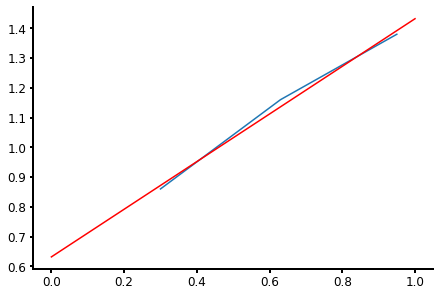

In [72]:
from scipy.stats import linregress

x = [.3, .63, .95]
y = [.86, 1.16, 1.38]
plt.plot(x, y)


#plot regression
xx = np.linspace(0, 1, 100)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(xx, intercept + slope*np.array(xx), 'r', label='fitted line')
